필사 Notebook
----
[Enefit: EDA + Catboost baseline](https://www.kaggle.com/code/syerramilli/enefit-eda-catboost-baseline)

In [3]:
# 필요한 라이브러리 불러오기
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime
from pathlib import Path
# import holidays

## 데이터 불러오기

In [4]:
# 데이터 불러오기
data_path = Path('predict_energy_dataset')

train = pd.read_csv(data_path / 'train.csv', parse_dates=['datetime'])

In [5]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


## EDA
* 데이터셋 확인
* 결측치 확인
* 시계열 데이터 시각화

### 데이터 확인

In [6]:
# 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [7]:
# 결측치 확인
train.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [8]:
# 결측치 있으면 행 제거
train = train.dropna(how='any')
train.shape[0]

2017824

### 데이터 시각화

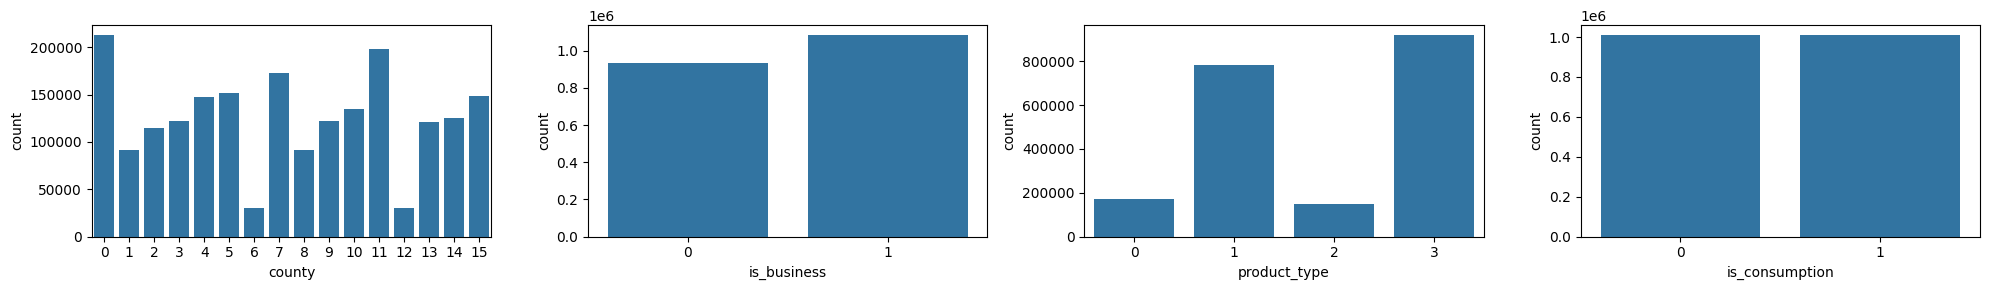

In [ ]:
# id를 제외한 수치형 데이터 추출
desc_columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 3))

# country, store, product 컬럼 시각화
for i, column in enumerate(desc_columns):
    _ = sns.countplot(train, x=column, ax=axs[i])

_ = fig.tight_layout()

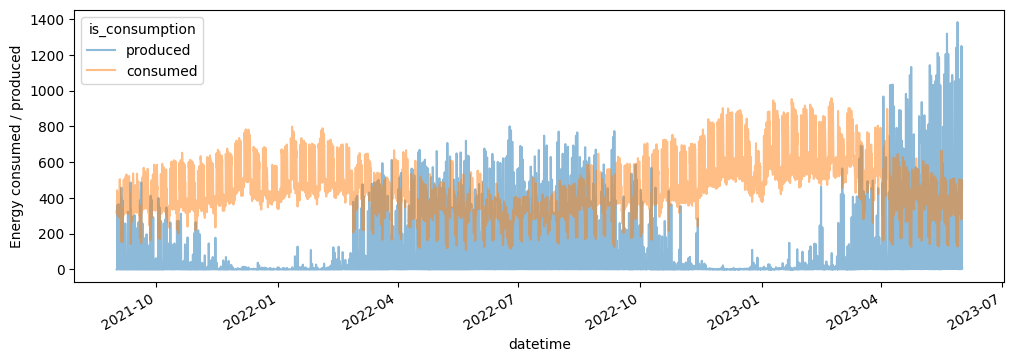

In [10]:
# 평균 production과 consumption 시계열 분석
train_avgd = (
    train
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

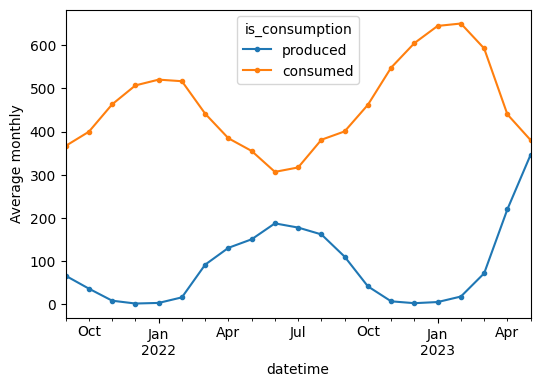

In [13]:
# 두 시리즈의 월별 평균 시각화
fig,ax = plt.subplots(1,1,figsize=(6,4))

_ = train_avgd.resample('ME').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

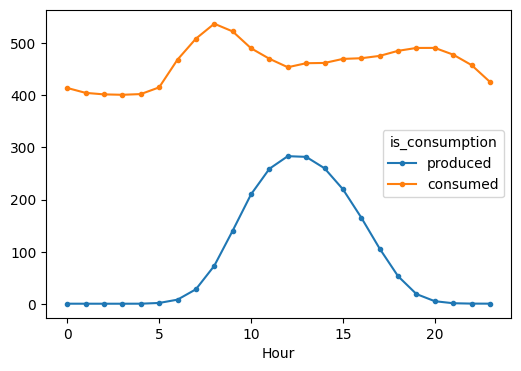

In [15]:
# 두 시리즈의 시간별 시각화
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

## 데이터 전처리

### 사인 및 코사인 변환
* 시간, 요일, 주, 월의 순환 연속성을 포착하기 위해 사인 및 코사인 변환을 포함

In [ ]:
# datetime 컬럼의 최소값으로 가장 이른 시각 구하기
earliest_time = train['datetime'].min()

# datetime의 날짜와 시간 정보를 각 컬럼으로 변환하는 함수
def extract_dt_attributes(df:pd.DataFrame):
    # datetime 컬럼을 datetime 타입으로 변환
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # date와 time, year 컬럼 생성
    df['date'] = df['datetime'].dt.date  # 날짜만 추출
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')  # 시간만 문자열로 추출
    df['year'] = df['datetime'].dt.year  # 연도 추출

    # earliest_time으로부터 며칠이 지났는지 계산
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days  
    
    # 시간 관련 피처와 범위 정의
    time_features = {
        'hour': [0, 23],         # 시: 0~23
        'dayofweek': [0, 6],     # 요일: 0(월)~6(일)
        'week': [1, 52],         # 주: 1~52
        'month': [1, 12]         # 월: 1~12
    }
    
    for col in time_features:
        # 주 컬럼일 경우, 추출 후 정수형 변환
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        # 나머지 컬럼은 바로 추출
        else:
            df[col] = getattr(df['datetime'].dt,col)
        
        # 주기성을 위해 sin, cos 변환
        col_min,col_max = time_features[col]  # 각 피처의 최소/최대값
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)  # 각도 계산
        
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')

In [ ]:
%%time

extract_dt_attributes(train)

CPU times: total: 4.38 s
Wall time: 8.46 s


In [ ]:
train.head(3)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5


### 지연 타겟 특성 생성
* 테스트 데이터는 2일 전의 타겟이 주어짐
* 이 정보를 사용해 2일 전의 지연된 타겟에 대한 특성 생성하기

In [ ]:
%%time

# data_block_id에 shift(2일 전)만큼 더한 컬럼 생성
shift = 2
train['data_block_id_shifted'] = train['data_block_id'] + shift

# 2일 전 타겟 값 train 데이터에 병합 (train 기준, 매칭되는 값이 없으면 NAN)
train = pd.merge(
    train,
    (
        train[[
            'county', 'is_business','is_consumption','product_type',
            'data_block_id_shifted', 'time', 'target']]
        .rename(columns={
            'data_block_id_shifted':'data_block_id', 
            'target':f'target_{shift}days_ago'
        })
    ),
    on = ['county', 'is_business','is_consumption','product_type', 'data_block_id', 'time'],
    how='left'
)

# rename 전 컬럼 삭제
del train['data_block_id_shifted']

train.head(2)

CPU times: total: 766 ms
Wall time: 963 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago_x,target_2days_ago_y,target_2days_ago
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN


In [ ]:
# 생산/소비와 target, lagged target 상관관계 나타내기
(
    train[['is_consumption', 'target', 'target_2days_ago']]
    .groupby('is_consumption')
    .corr()
    .round(3)
)

target  target_2days_ago
is_consumption                                           
0              target             1.000             0.822
               target_2days_ago   0.822             1.000
1              target             1.000             0.946
               target_2days_ago   0.946             1.000

### 추가 데이터 확인
* Electricity prices
* Gas prices
* Client information
* Forecasted Weather Attributes


Electricity prices

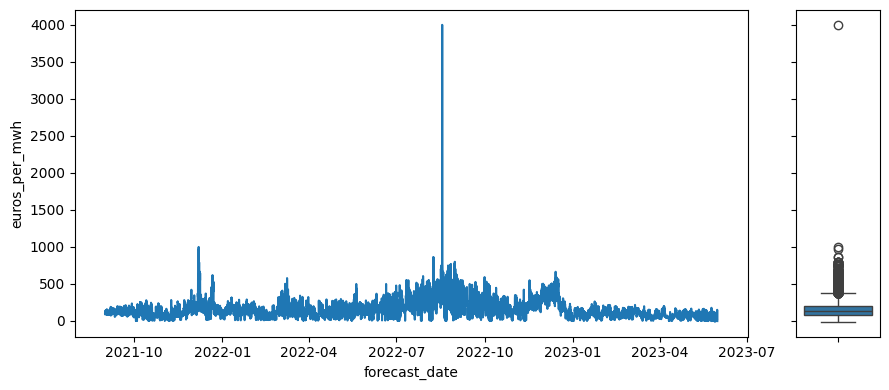

In [ ]:
# 전력 시장의 시간별 도매 가격 데이터셋 불러오기
electricity_prices = pd.read_csv(data_path / 'electricity_prices.csv')

# datetime으로 변환 후 시간만 문자열로 추출
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')

# 데이터 시각화 
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)

# 왼쪽: 예측 가격이 적용되어야 할 미래 날짜에 따른 전력 가격
_ = sns.lineplot(electricity_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])

# 오른쪽: 전력 가격 분포
_ = sns.boxplot(electricity_prices, y='euros_per_mwh', ax=axs[1])

#_ = axs[1].get_yaxis().set_visible(False)  y축 숨기기

fig.tight_layout()

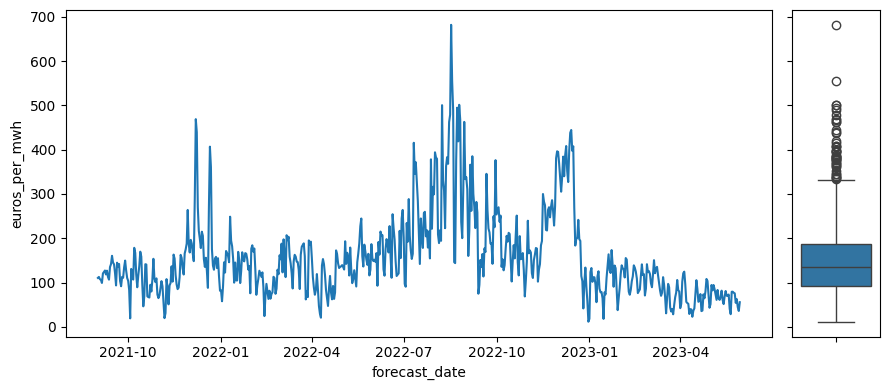

In [33]:
# 일별 평균 전력 가격에 대한 예측 시각화
daily_elec_prices = (
    electricity_prices[['forecast_date', 'euros_per_mwh']]
    .set_index('forecast_date')
    .resample('D')
    .mean()
)

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(daily_elec_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(daily_elec_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

In [34]:
%%time

# 전력 가격 train 데이터에 병합 (train 기준, 매칭되는 값이 없으면 NAN)
train = pd.merge(
    train,
    electricity_prices[['time', 'data_block_id', 'euros_per_mwh']],
    how = 'left',
    on = ['time', 'data_block_id'] 
)

train.head()

CPU times: total: 328 ms
Wall time: 471 ms


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago_x,target_2days_ago_y,target_2days_ago,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,35,-0.822984,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN


Gas prices (시간별 예측이 아닌 일일 예측)

In [35]:
# 가스 시장 가격 정보 데이터셋 불러오기
gas_prices =  pd.read_csv(data_path / 'gas_prices.csv')

# datetime으로 변환
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])

gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


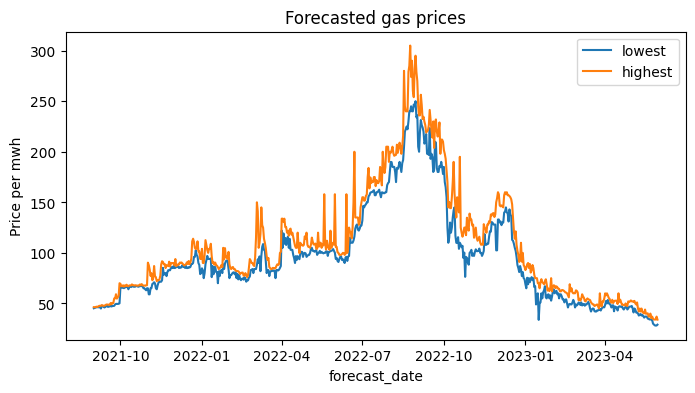

In [36]:
# 가스 가격 예측 시각화
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# 최저, 최고 가스 가격 라인 플롯 
_ = sns.lineplot(gas_prices, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(gas_prices, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')

_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

In [37]:
# 최저, 최고 가스 가격 train 데이터에 병합 (train 기준, 매칭되는 값이 없으면 NAN)
train = pd.merge(
    train,
    gas_prices[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
    how = 'left',
    on = ['data_block_id'] 
)

train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week_cosine,month,month_sine,month_cosine,target_2days_ago_x,target_2days_ago_y,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,-0.568065,9,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN


Client information

In [40]:
# 프로슈머의 정보 데이터셋 불러오기
client = pd.read_csv(data_path / 'client.csv')

# 프로슈머 정보 train 데이터에 병합 (train 기준, 매칭되는 값이 없으면 NAN)
train = pd.merge(
    train,
    client.drop('date', axis=1),
    on = ['data_block_id', 'product_type', 'county', 'is_business'],
    how='left'
)

train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,month_sine,month_cosine,target_2days_ago_x,target_2days_ago_y,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,-0.866025,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Forecasted Weather Attributes    
- 카운티 코드를 날씨 파일의 위도와 경도 좌표에 매핑하는 데이터프레임: https://www.kaggle.com/code/fabiendaniel/mapping-locations-and-county-codes     
- 속성을 추가하는 코드: https://www.kaggle.com/code/patrick0302/more-revealed-from-target-revealed

In [41]:
# 카운티 코드 정보 데이터셋 불러오기
location = pd.read_csv(data_path / "county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

# float의 부정확성을 피하기 위해 int로 변환
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

print(location.shape)
location.sample(5, random_state=1)

(75, 3)


,county,longitude,latitude
19,2,277,594
55,10,222,582
10,1,217,588
70,15,267,576
54,10,217,582


<Axes: ylabel='county'>

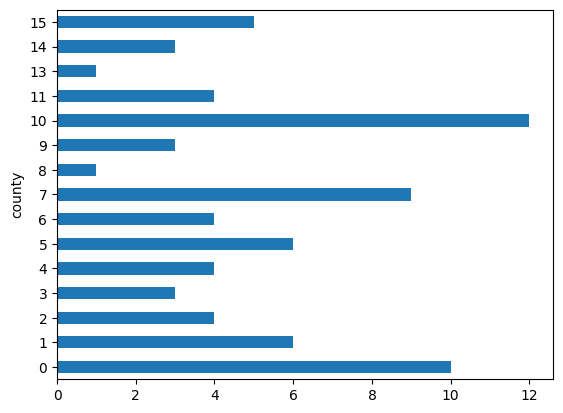

In [ ]:
# 카운티 코드별 갯수 시각화
location.county.value_counts().sort_index().plot(kind='barh')

In [44]:
# 날씨 데이터 전처리 함수
def process_weather_info(weather:pd.DataFrame, location=location) :
    # 날씨 데이터 중복 제거
    weather = weather.drop_duplicates().reset_index(drop=True)

    # float의 부정확성을 피하기 위해 정수로 변환
    for k in ['latitude', 'longitude'] :
        weather[k] = (10*weather[k]).astype(int)
    
    # 날씨에 위치 정보 추가
    weather = pd.merge(weather, location, how='left', on=['latitude', 'longitude'])
    
    # 결측값을 -1로 채우고 정수형으로 변환
    weather['county'] = weather['county'].fillna(-1).astype(int)

    return weather

In [ ]:
%%time 

# 날씨 예보 데이터셋 불러오기
forecast_weather = pd.read_csv(data_path / 'forecast_weather.csv')

# 위치 정보 추가하기
forecast_weather = process_weather_info(forecast_weather)

print(forecast_weather.shape)
forecast_weather.head(5)

(3424512, 19)
CPU times: total: 6.44 s
Wall time: 9.58 s


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
0,576,217,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1
1,576,222,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1
2,576,227,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1
3,576,232,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10
4,576,237,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1


In [ ]:
%%time
# 집계 피처 생성

# 집계할 컬럼과 범위 정의
dict_agg = {
    'temperature': ['min', 'mean', 'max'],          # 온도
    'dewpoint': ['min', 'mean', 'max'],            # 이슬점 온도
    'direct_solar_radiation': ['min', 'mean', 'max'],  # 직사광선 복사량
    'surface_solar_radiation_downwards': ['min', 'mean', 'max']  # 지면에 도달한 총 복사량
}

# 카운티와 예보 시간을 기준으로 그룹화
keys = ['county', 'forecast_datetime']
forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

# 다중 인덱스를 단일 문자열로 변환 
forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]

# 키 컬럼을 제외한 모든 컬럼에 '_f' 추가
forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]

print(forecast_weather.shape)
forecast_weather.head(2)

(244960, 14)
CPU times: total: 391 ms
Wall time: 606 ms


,county,forecast_datetime,temperature_min_f,temperature_mean_f,temperature_max_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f
0,-1,2021-09-01 03:00:00,9.783228,13.162114,16.003564,8.423364,11.012977,12.878687,0.0,0.0,0.0,0.0,0.0,0.0
1,-1,2021-09-01 04:00:00,9.828760,13.108703,15.790552,8.596460,10.802036,12.211328,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
%%time 

forecast_weather['forecast_datetime'] = (
    # datetime 타입으로 변환
    pd.to_datetime(forecast_weather['forecast_datetime'])
    # 시간대 정보 제거하고 None으로 설정
    .dt.tz_localize(None)  
)

# 날씨 데이터 train 데이터에 병합 (train 기준, 매칭되는 값이 없으면 NAN)
train = pd.merge(
    train, 
    forecast_weather.rename(columns = {'forecast_datetime': 'datetime'}),
    how = 'left',
    on = ['county', 'datetime']
)

print(train.shape)

(2017824, 45)
CPU times: total: 344 ms
Wall time: 515 ms


In [49]:
# 생산/소비와 추가 데이터들, target의 상관관계 나타내기
(
    train[[
        'is_consumption', 'target', 
        'euros_per_mwh',
        'lowest_price_per_mwh', 'highest_price_per_mwh',
        'eic_count', 'installed_capacity',
        # 날씨
        'temperature_mean_f', 
        'dewpoint_mean_f',
        'direct_solar_radiation_mean_f',
        'surface_solar_radiation_downwards_mean_f'
    ]]
    .groupby('is_consumption')
    .corr()
    ['target']
    .unstack()
    .iloc[:, 1:]
    .round(3)
)

,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_mean_f,dewpoint_mean_f,direct_solar_radiation_mean_f,surface_solar_radiation_downwards_mean_f
is_consumption,,,,,,,,,
0,-0.018,0.012,0.009,0.340,0.357,0.204,0.100,0.416,0.461
1,0.018,-0.026,-0.023,0.336,0.809,-0.071,-0.057,-0.052,-0.054


## 모델 학습 및 예측

In [54]:
# lightgbm regressor
from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

import optuna
import joblib


from typing import Optional,Dict,Tuple

plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi': 150})

In [50]:
# 특성을 나타내는 컬럼이 아닌 컬럼들 추출
not_feature_columns = [
    'datetime', 
    'row_id',
    'prediction_unit_id',
    'date',
    'time'
]

In [51]:
# datetime으로 학습 데이터셋 정렬
# 학습 데이터 정의 (학습에 필요없는 데이터 제외)
X = train.drop(['target', 'data_block_id'] + not_feature_columns, axis=1)
y = train['target']

In [52]:
# 교차 검증에 사용 
# 연도와 월 컬럼을 datetime으로 변환하고 각 달의 1일로 설정
# 중복 제거 후 정렬된 배열 생성
timesteps = np.sort(np.array(
    pd.to_datetime(X[['year', 'month']].assign(day=1)).unique().tolist()
))

timesteps

array([Timestamp('2021-09-01 00:00:00'), Timestamp('2021-10-01 00:00:00'),
       Timestamp('2021-11-01 00:00:00'), Timestamp('2021-12-01 00:00:00'),
       Timestamp('2022-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00'),
       Timestamp('2022-03-01 00:00:00'), Timestamp('2022-04-01 00:00:00'),
       Timestamp('2022-05-01 00:00:00'), Timestamp('2022-06-01 00:00:00'),
       Timestamp('2022-07-01 00:00:00'), Timestamp('2022-08-01 00:00:00'),
       Timestamp('2022-09-01 00:00:00'), Timestamp('2022-10-01 00:00:00'),
       Timestamp('2022-11-01 00:00:00'), Timestamp('2022-12-01 00:00:00'),
       Timestamp('2023-01-01 00:00:00'), Timestamp('2023-02-01 00:00:00'),
       Timestamp('2023-03-01 00:00:00'), Timestamp('2023-04-01 00:00:00'),
       Timestamp('2023-05-01 00:00:00')], dtype=object)

### 모델 정의

In [56]:
def fit_model(
    X:pd.DataFrame,
    y:pd.Series,
    config:Optional[Dict]=None,  # 모델 하이퍼파라미터 설정값
    n_jobs:int=1,       # 병렬 처리에 사용할 스레드 수
    verbose:int=0       # 학습 과정 출력 여부
) -> CatBoostRegressor:
    '''
    L1 손실함수를 사용하는 CatBoost 회귀 모델 학습
    '''

    # CatBoost 모델 초기화
    model = CatBoostRegressor(
        n_estimators=100,        # 트리의 개수 
        objective='MAE',         # 평균절대오차(MAE)를 최소화하는 목적함수 사용
        thread_count=n_jobs,     # 병렬 처리 스레드 수
        bootstrap_type="Bernoulli",  # 베르누이 분포를 이용한 부트스트랩 방식
        sampling_frequency='PerTree', # 각 트리마다 샘플링 수행
        verbose=verbose,         # 학습 진행상황 출력 여부
        cat_features=['county', 'product_type'],  # 범주형 변수 지정
        leaf_estimation_iterations=1  # 리프 노드 값 추정 반복 횟수
    )
    
    if config:
        # 하이퍼파라미터 설정
        model.set_params(**config)
        
    # 모델 학습
    return model.fit(X,y)

### Optuna로 하이퍼파라미터 튜닝

In [58]:
def fit_and_test_fold(config:Dict, X, y, year_month_train, year_month_test) -> float:
    # 연도와 월을 이용해 해당 달의 첫째 날로 datetime 생성
    first_dates_month = pd.to_datetime(X[['year', 'month']].assign(day=1))
    
    # 학습, 테스트에 사용할 인덱스 생성
    train_index = first_dates_month.isin(year_month_train)
    test_index = first_dates_month.isin(year_month_test)
    
    # 학습, 테스트 데이터 분리
    X_train = X[train_index];X_test = X[test_index]
    y_train = y[train_index]; y_test = y[test_index]
    
    # 모델 학습
    model = fit_model(X_train, y_train, config, n_jobs=4)
    
    # 예측
    y_test_pred = model.predict(X_test)
    
    # MAE 반환
    return mean_absolute_error(y_test, y_test_pred)

# Optuna에서 사용할 loss function
def objective(trial):
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'learning_rate': trial.suggest_float('learning_rate', 5e-3, 0.75,log=True),
        'depth': trial.suggest_int('depth', 2, 10, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8,100,log=True),
        'model_size_reg': trial.suggest_float('model_size_reg',1e-8,100,log=True),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.1, 1),
        'subsample': trial.suggest_float("subsample", 0.5, 1)
    }
    
    # 시계열 교차검증 분할기 생성
    cv = TimeSeriesSplit(n_splits=3)
    cv_mae = [None]*3
    for i, (train_index, test_index) in enumerate(cv.split(timesteps)):
        # 각 fold별로 학습 및 평가
        cv_mae[i] = fit_and_test_fold(config, X, y, timesteps[train_index], timesteps[test_index])
        
    # 각 fold별 MAE를 trial에 저장
    trial.set_user_attr('split_mae', cv_mae)
    
    # 3개 fold의 MAE 평균값 반환
    return np.mean(cv_mae)

# Optuna 샘플러(TPE) 설정
sampler = optuna.samplers.TPESampler(
    n_startup_trials=10, seed=1234
)

# Optuna 스터디 생성 (최소화 목표)
study = optuna.create_study(
    directions=['minimize'],sampler=sampler,study_name='catboost'
)

# 최대 50번 시도 또는 2시간 동안 하이퍼파라미터 탐색 수행
study.optimize(objective, n_trials=50, timeout= 7200)

# 결과 pickle 파일로 저장
_ = joblib.dump(study, 'catboost_enefit_hyperopt.pkl')

[I 2025-05-18 15:44:03,286] A new study created in memory with name: catboost
[I 2025-05-18 15:44:55,588] Trial 0 finished with value: 93.16808469624375 and parameters: {'n_estimators': 88, 'learning_rate': 0.11291079445795757, 'depth': 4, 'l2_leaf_reg': 0.7138152748525232, 'model_size_reg': 0.6306059747250776, 'colsample_bylevel': 0.3453333447543775, 'subsample': 0.6382321275715483}. Best is trial 0 with value: 93.16808469624375.
[I 2025-05-18 15:49:54,762] Trial 1 finished with value: 77.16165214182011 and parameters: {'n_estimators': 211, 'learning_rate': 0.6080911415909925, 'depth': 8, 'l2_leaf_reg': 3.785931044085381e-05, 'model_size_reg': 0.001023178145374356, 'colsample_bylevel': 0.7151166416549226, 'subsample': 0.85635101349145}. Best is trial 1 with value: 77.16165214182011.
[I 2025-05-18 15:51:20,573] Trial 2 finished with value: 91.10929252837364 and parameters: {'n_estimators': 124, 'learning_rate': 0.08321164726928963, 'depth': 4, 'l2_leaf_reg': 1.3730441303373621e-08, 'mo

In [ ]:
# Optuna의 최적화 과정 시각화
fig = optuna.visualization.plot_optimization_history(study, target_name='Validation MAE')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)

fig.show()

### 최종 모델 학습

In [68]:
# Optuna로 찾은 최적의 하이퍼파라미터 사용해 모델 학습
model = fit_model(X, y, n_jobs=4, config=study.best_params, verbose=20)

0:	learn: 247.0762232	total: 981ms	remaining: 4m 4s
20:	learn: 77.3707560	total: 19.1s	remaining: 3m 28s
40:	learn: 61.2334638	total: 36.3s	remaining: 3m 4s
60:	learn: 58.2590729	total: 53.8s	remaining: 2m 46s
80:	learn: 57.2794884	total: 1m 10s	remaining: 2m 26s
100:	learn: 52.7660648	total: 1m 27s	remaining: 2m 8s
120:	learn: 50.5627742	total: 1m 44s	remaining: 1m 51s
140:	learn: 48.1662296	total: 2m 1s	remaining: 1m 33s
160:	learn: 46.3632561	total: 2m 18s	remaining: 1m 16s
180:	learn: 45.5552023	total: 2m 35s	remaining: 59.3s
200:	learn: 44.3195890	total: 2m 51s	remaining: 41.8s
220:	learn: 43.2961184	total: 3m 8s	remaining: 24.7s
240:	learn: 42.2961847	total: 3m 25s	remaining: 7.69s
249:	learn: 41.7492944	total: 3m 33s	remaining: 0us


In [69]:
model.save_model('catboost_energy_pred.cbm',format='cbm')

In [70]:
y_pred = model.predict(X)
train_mae = mean_absolute_error(y, y_pred)
print(f'Train MAE: {train_mae:.3f}')

Train MAE: 41.688


피처 중요도 확인
* catboost와 같은 트리 기반 모델의 특성 중요도 측정값은 오해의 소지가 있기 때문에, 가장 신뢰할 수는 없음
* catboost에서 기본 특성 중요도 측정값은 특성이 포함된 분할의 총 이득을 기반으로 진행

<Axes: >

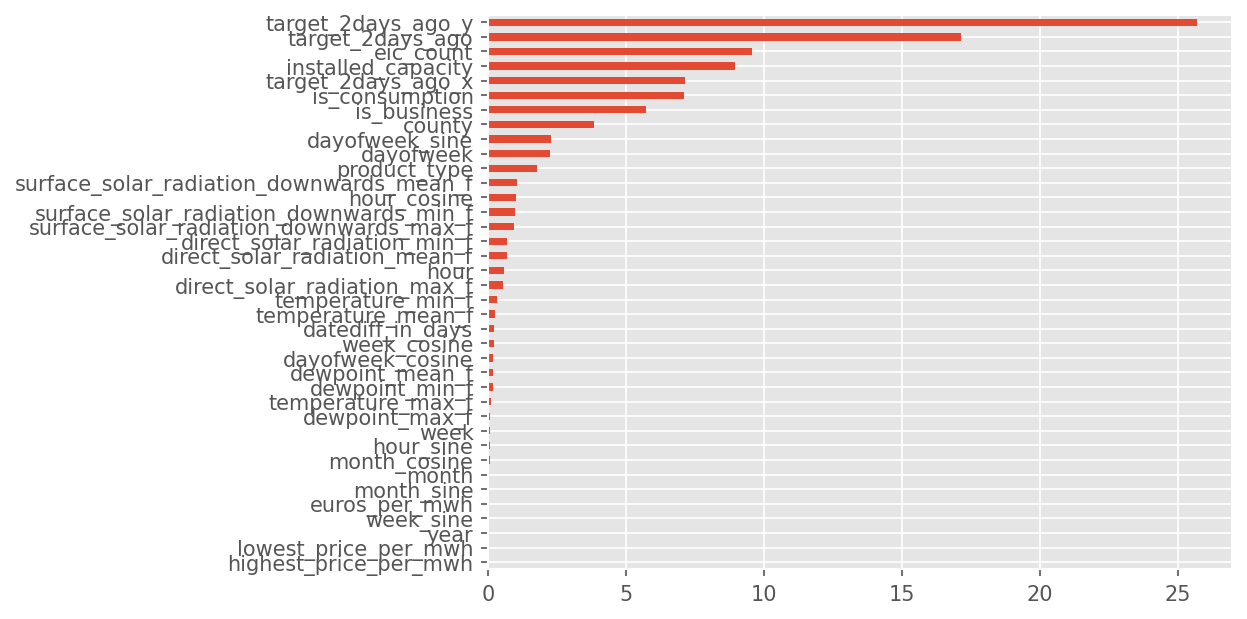

In [71]:
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

### 테스트 데이터 처리
feature engineering and additional features

In [72]:
def get_final_df(df, revealed_targets, client, forecast_weather, electricity_prices, gas_prices):
    
    # datetime의 날짜와 시간 정보를 각 컬럼으로 변환하는 함수
    extract_dt_attributes(df)
    
    # 2일 지연 타겟 특성 생성
    revealed_targets = revealed_targets.rename(columns={'target':'target_2days_ago'})
    revealed_targets['datetime'] = pd.to_datetime(revealed_targets['datetime']) + pd.Timedelta(days=2)
    df = pd.merge(
        df,
        revealed_targets[
            ['county', 'is_business','is_consumption','product_type', 'datetime', 'target_2days_ago']
        ],
        how='left',
        on=['county', 'is_business','is_consumption','product_type', 'datetime']
    )
    
    # Electricity prices
    electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
    electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')
    electricity_prices['date'] = (electricity_prices['forecast_date'] + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, electricity_prices[['time', 'date', 'euros_per_mwh']],
        how = 'left',
        on = ['time', 'date'] 
    )
    
    # Gas prices
    gas_prices['date'] = (pd.to_datetime(gas_prices['forecast_date']) + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, gas_prices[['date', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
        how = 'left',
        on = ['date'] 
    )
    
    # Client information
    client['date'] = (client['date'] + pd.Timedelta(days=2)).dt.date
    
    df = pd.merge(
        df, client,
        how='left',
        on = ['date', 'product_type', 'county', 'is_business'],
    )
    
    # Forecast weather
    forecast_weather = process_weather_info(forecast_weather)
    
    dict_agg = {
        'temperature': ['min', 'mean', 'max'],
        'dewpoint': ['min', 'mean', 'max'],
        'direct_solar_radiation': ['min', 'mean', 'max'],
        'surface_solar_radiation_downwards': ['min', 'mean', 'max']
    }

    keys = ['county', 'forecast_datetime']
    forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

    # 다중 인덱스를 단일 문자열로 변환
    forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]

    # 키 컬럼을 제외한 모든 컬럼에 '_f' 추가
    forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]
    
    # datetime 타입으로 변한, 시간대 정보 제거하고 None으로 설정
    forecast_weather['forecast_datetime'] = (
        pd.to_datetime(forecast_weather['forecast_datetime'])
        .dt.tz_localize(None)
    )
    
    df = pd.merge(
        df, 
        forecast_weather.rename(columns = {'forecast_datetime': 'datetime'}),
        how = 'left',
        on = ['county', 'datetime']
    )
    
    return df

In [ ]:
import enefit

# 테스트 환경 생성
env = enefit.make_env()
iter_test = env.iter_test()

# 테스트 데이터에 대한 예측 수행
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    # prediction_datetime 컬럼명을 datetime으로 변경
    test = test.rename(columns={'prediction_datetime':'datetime'})

    # 최종 테스트 데이터프레임 생성
    test = get_final_df(test, revealed_targets, client, forecast_weather, electricity_prices, gas_prices)
    
    # 특성 컬럼만 선택
    X_test = test.drop(not_feature_columns, axis=1)
    
    # 예측
    sample_prediction['target'] = model.predict(X_test)

    # env.predict(sample_prediction)